In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Input,
    Embedding, Dot, Dense, Flatten
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, LearningRateScheduler,
    TensorBoard, EarlyStopping
)
from wordcloud import WordCloud

%matplotlib inline


In [3]:
import os
import numpy as np

In [4]:
INPUT_DIR = os.path.join("..", "artifacts", "raw")

In [5]:
rating_df = pd.read_csv(INPUT_DIR + "/animelist.csv", low_memory=True, usecols=['user_id', 'anime_id', 'rating'])

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
##Data Processing

n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy()

In [8]:
len(rating_df)

3246641

In [9]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])

In [10]:
min_rating

0

In [11]:
max_rating

10

In [12]:
avg_rating = rating_df["rating"].mean()


In [13]:
avg_rating

np.float64(4.122732695114736)

In [14]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float32)

In [15]:
rating_df.duplicated().sum()

np.int64(0)

In [16]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [17]:
user_id = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i, x in enumerate(user_id)}
user2user_decoded = {i : x for i, x in enumerate(user_id)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [18]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [19]:
n_users = len(user2user_encoded)

In [20]:
n_users

4203

In [21]:
anime_id = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i, x in enumerate(anime_id)}
anime2anime_decoded = {i : x for i, x in enumerate(anime_id)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [22]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [23]:
n_anime = len(anime2anime_encoded)

In [24]:
n_anime

17149

In [25]:
rating_df = rating_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [26]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"].values

In [27]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [28]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [29]:
len(X_train)

3245641

In [30]:
len(X_test)

1000

In [31]:
type(X_train)

numpy.ndarray

In [32]:
X_train_array = [X_train[: , 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [33]:
type(X_train_array)

list

In [34]:
type(X_train_array[0])

numpy.ndarray

In [35]:
def RecomenderNet():
    embedding_size = 128
    user = Input(name="user", shape = [1])
    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)
    anime = Input(name="anime", shape = [1])
    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)
    x = Dot(name="dot_product", normalize = True, axes = 2)([user_embedding, anime_embedding])
    x= Flatten()(x)
    x = Dense(1, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss="binary_crossentropy", metrics=["mae", "mse"], optimizer="Adam")
    return model   

In [36]:
model = RecomenderNet()

In [37]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [38]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000
ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfm(epoch):
    if epoch<ramup_epochs:
        return (max_lr - start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr)*exp_decay**(epoch-ramup_epochs-sustain_epochs) + min_lr
    


In [39]:
lr_callback = LearningRateScheduler(lambda epoch:lrfm(epoch), verbose=0)
checkpoint_filepath = '.weights.weights.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)
early_stopping = EarlyStopping(patience=3, monitor="val-loss", mode="min", restore_best_weights=True)

In [40]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [41]:
history = model.fit(
    x = X_train_array,
    y=y_train,
    batch_size = batch_size,
    epochs  = 20,
    verbose = 1, 
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.8021 - mae: 0.3824 - mse: 0.1978 - val_loss: 0.7527 - val_mae: 0.3775 - val_mse: 0.1827 - learning_rate: 1.0000e-05
Epoch 2/20
  1/325 ━━━━━━━━━━━━━━━━━━━━ 45s 140ms/step - loss: 0.7968 - mae: 0.3771 - mse: 0.1932

d:\My folder 2025\python for data science\projects\Anime Recommender System\venv310\lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val-loss` which is not available. Available metrics are: loss,mae,mse,val_loss,val_mae,val_mse,learning_rate
  current = self.get_monitor_value(logs)


325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7986 - mae: 0.3811 - mse: 0.1964 - val_loss: 0.8081 - val_mae: 0.3873 - val_mse: 0.2013 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7926 - mae: 0.3788 - mse: 0.1940 - val_loss: 0.8096 - val_mae: 0.3874 - val_mse: 0.2016 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.7840 - mae: 0.3755 - mse: 0.1906 - val_loss: 0.8049 - val_mae: 0.3862 - val_mse: 0.2000 - learning_rate: 3.4000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.7721 - mae: 0.3707 - mse: 0.1858 - val_loss: 0.7974 - val_mae: 0.3837 - val_mse: 0.1972 - learning_rate: 4.2000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7549 - mae: 0.3634 - mse: 0.1787 - val_loss: 0.7827 - val_mae: 0.3779 - val_mse: 0.1915 - learning_rate: 5.0000e-05
Epoch 7/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7257 - mae: 0.3499 - mse: 0.1665 - val_loss: 0.7493 -

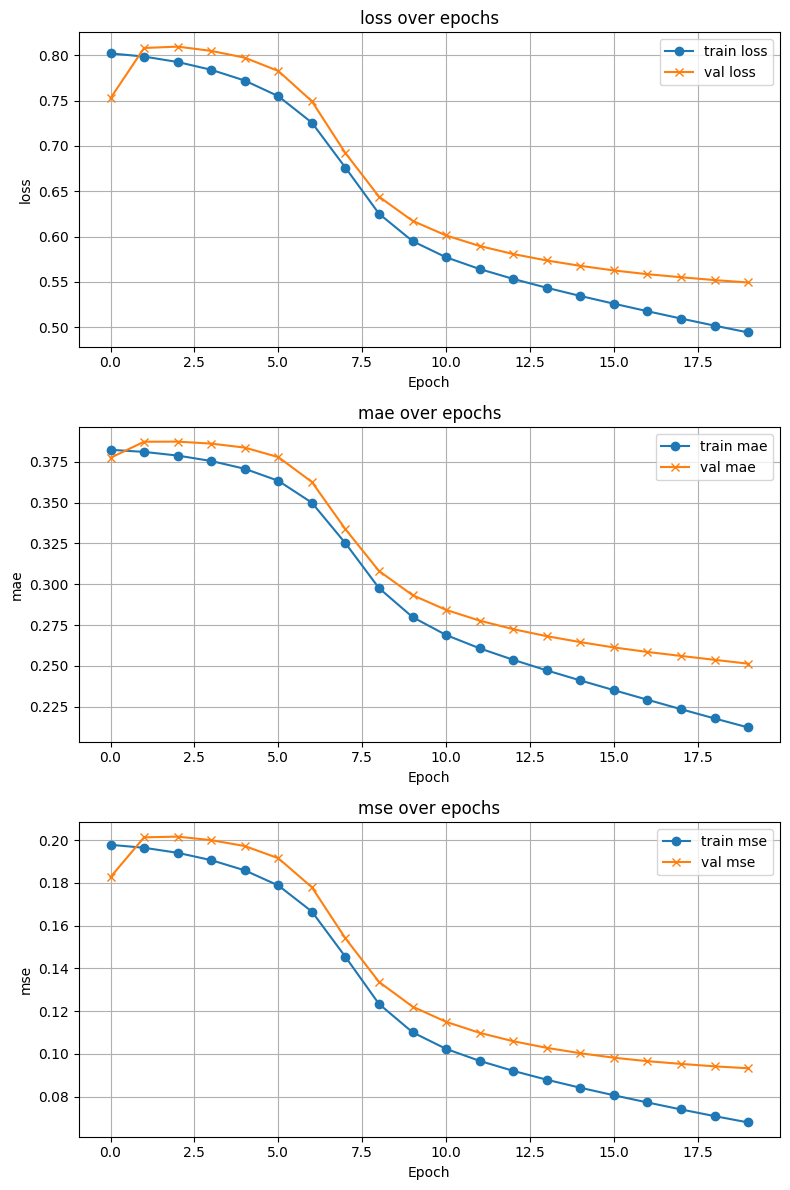

In [42]:
import matplotlib.pyplot as plt

# Metrics to visualize
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    # Plot training metric
    ax.plot(history.history[metric], marker='o', label=f"train {metric}")
    # Plot validation metric
    val_metric = 'val_' + metric
    if val_metric in history.history:
        ax.plot(history.history[val_metric], marker='x', label=f"val {metric}")
    
    ax.set_title(f'{metric} over epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [43]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

In [44]:
anime_weights = extract_weights("anime_embedding", model)

In [45]:
user_weights = extract_weights("user_embedding", model)

In [46]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)

In [47]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [48]:
df = df.replace("Unknown", np.nan)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [51]:
def getAninemName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [52]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df['eng_version'] = df.anime_id.apply(lambda x: getAninemName(x))

In [53]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [54]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind='quicksort',
               na_position='last')

In [55]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [56]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456


In [57]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id==anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]


In [60]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [61]:
## ANIME WITH SYNOPSIS csv

In [67]:
cols= ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [69]:
synopsis_df = pd.read_csv(INPUT_DIR + "/anime_with_synopsis.csv", usecols=cols)

In [70]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [73]:
def getSynopsis(anime, df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [74]:
getSynopsis(40028, df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [75]:
## COntent / based recomendation

In [76]:
pd.set_option("max_colwidth", None)

In [1]:
def find_simmilar_animes(name, 
                         anime_weights, 
                         anime2anime_encoded, 
                         anime2anime_decoded, 
                         df, 
                         synopsis_df, 
                         n=10, 
                         return_dist=False, 
                         neg=False):
    try:
        # Get anime index
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        # Compute similarity
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dist = np.argsort(dists)

        n = n + 1  # include the anime itself
        if neg:
            closest = sorted_dist[:n]        # least similar
        else:
            closest = sorted_dist[-n:]       # most similar

        print(f"Anime closest to {name}:")

        if return_dist:
            return dists, closest

        SimilarityArr = []
        for close in closest:
            decoded_d = anime2anime_decoded.get(close)
            anime_frame = getAnimeFrame(decoded_d, df)

            # Skip if anime_frame is empty
            if anime_frame.empty:
                continue

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            synopsis = getSynopsis(decoded_d, synopsis_df)
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id": decoded_d,
                "name": anime_name,
                "similarity": similarity,
                "genres": genre,
                "synopsis": synopsis
            })

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"], axis=1)

    except Exception as e:
        print("Error in find_simmilar_animes:", e)
        return pd.DataFrame()


In [2]:
find_simmilar_animes("Cowboy Bebop",
                     anime_weights,
                     anime2anime_encoded,
                     anime2anime_decoded,
                     df, 
                     synopsis_df)

NameError: name 'anime_weights' is not defined